# Data Processing


## Initial Steps

In [1]:
# Setup
from pathlib import Path
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")


We'll locate the files and prepare for concatenation into the final dataset. Firstly, we'll pull the files into a consolidated dataframe to determine what transformations may need to happen before consolidating to a final dataframe.

In [ ]:
folder_path = ('../DataSciencePortfolio/White House Visitor Log Analysis/whlogs')
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')] # get all filenames


The below loop reads each file and prepares them for appendation to the final dataframe in the next cell.

In [3]:
df_list =[] # init list for dfs
for file in csv_files:
    file_path = os.path.join(folder_path, file) # create full filename
    df = pd.read_csv(file_path, low_memory = False)  # read into df w/ dtypes; low_memory = False to suppress warnings
    df_list.append(df)  # append for final listing


In [4]:
final_df = pd.concat(df_list, ignore_index=True) # final concatenation
final_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207458 entries, 0 to 1207457
Data columns (total 49 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   NAMELAST                 84445 non-null    object 
 1   NAMEFIRST                84446 non-null    object 
 2   NAMEMID                  84446 non-null    object 
 3   UIN                      1206944 non-null  object 
 4   BDGNBR                   173716 non-null   float64
 5   ACCESS_TYPE              84446 non-null    object 
 6   TOA                      844689 non-null   object 
 7   POA                      20916 non-null    object 
 8   TOD                      12820 non-null    object 
 9   POD                      124359 non-null   object 
 10  APPT_MADE_DATE           84446 non-null    object 
 11  APPT_START_DATE          84446 non-null    object 
 12  APPT_END_DATE            84446 non-null    object 
 13  APPT_CANCEL_DATE         440 non-null     

49 fields and 1.2 million records is a lot of data. Further scrutiny reveals potential duplicate data in the columns that may be inflating the data. It would be prudent to scrub each to create a more workable dataframe.


## Pointless Duplicate Cleaning Effort You May Skip


To clean the datasets, I'll define each datatype explicitly, then outline potential duplicate columns to address. Following the cleaning, a logical procedure will scrub the data of duplicates if the columns qualify according to the logic.

### Dtype & Redundant Column listing

In [5]:
dtype_dict = {
    'NAMELAST': 'object',
    'NAMEFIRST': 'object',
    'NAMEMID': 'object',
    'UIN': 'object',
    'BDGNBR': 'float64',
    'ACCESS_TYPE': 'object',
    'TOA': 'object',
    'POA': 'object',
    'TOD': 'object',
    'POD': 'object',
    'APPT_MADE_DATE': 'object',
    'APPT_START_DATE': 'object',
    'APPT_END_DATE': 'object',
    'APPT_CANCEL_DATE': 'object',
    'TOTAL_PEOPLE': 'float64',
    'LAST_UPDATEDBY': 'object',
    'POST': 'object',
    'LASTENTRYDATE': 'object',
    'TERMINAL_SUFFIX': 'object',
    'VISITEE_NAMELAST': 'object',
    'VISITEE_NAMEFIRST': 'object',
    'MEETING_LOC': 'object',
    'MEETING_ROOM': 'object',
    'CALLER_NAME_LAST': 'object',
    'CALLER_NAME_FIRST': 'object',
    'CALLER_ROOM': 'float64',
    'RELEASEDATE': 'object',
    'Unnamed: 27': 'object',
    'Unnamed: 28': 'object',
    'Last Name': 'object',
    'First Name': 'object',
    'Middle Initial': 'object',
    'Access Type': 'object',
    'Appointment Made Date': 'object',
    'Appointment Start Date': 'object',
    'Appointment End Date': 'object',
    'Appointment Cancel Date': 'object',
    'Total People': 'float64',
    'Last Updated By': 'object',
    'Last Entry Date': 'object',
    'Terminal Suffix': 'object',
    'Visitee Last Name': 'object',
    'Visitee First Name': 'object',
    'Meeting Location': 'object',
    'Meeting Room': 'object',
    'Caller Last Name': 'object',
    'Caller First Name': 'object',
    'Caller Room': 'float64',
    'Release Date': 'object',
}
duplicated_columns = [
    ('NAMELAST', 'Last Name'),
    ('NAMEFIRST', 'First Name'),
    ('NAMEMID', 'Middle Initial'),
    ('ACCESS_TYPE', 'Access Type'),
    ('APPT_MADE_DATE', 'Appointment Made Date'),
    ('APPT_START_DATE', 'Appointment Start Date'),
    ('APPT_END_DATE', 'Appointment End Date'),
    ('APPT_CANCEL_DATE', 'Appointment Cancel Date'),
    ('TOTAL_PEOPLE', 'Total People'),
    ('LAST_UPDATEDBY', 'Last Updated By'),
    ('LASTENTRYDATE', 'Last Entry Date'),
    ('TERMINAL_SUFFIX', 'Terminal Suffix'),
    ('VISITEE_NAMELAST', 'Visitee Last Name'),
    ('VISITEE_NAMEFIRST', 'Visitee First Name'),
    ('MEETING_LOC', 'Meeting Location'),
    ('MEETING_ROOM', 'Meeting Room'),
    ('CALLER_NAME_LAST', 'Caller Last Name'),
    ('CALLER_NAME_FIRST', 'Caller First Name'),
    ('RELEASEDATE', 'Release Date')
]


### Reading & Cleaning

We'll repeat the reading process, but this time include logic to handle potential duplicate data by removing entire duplicate columns where the data is identical to the suspected duplicates.

In [6]:
df_list = [] # init list for dfs
mismatched_columns = {} # init empty collector for mismatched columns
for file in csv_files:
    file_path = os.path.join(folder_path, file) # create full filename
    df = pd.read_csv(file_path, dtype=dtype_dict)  # read into df w/ dtypes
    df_list.append(df)  # append for final listing
    
    # pairwise compare potential duplicate columns by datatype
    for col1, col2 in duplicated_columns:
        if col1 in df.columns and col2 in df.columns:
            type1 = df[col1].dtype
            type2 = df[col2].dtype
            
            # non-matches are unique and therefore stored
            if type1 != type2:
                if (col1, col2) not in mismatched_columns:
                    mismatched_columns[(col1, col2)] = (type1, type2)
            else:
                # if dtypes match, check for identical records, then remove duplicates
                if df[col1].equals(df[col2]):
                    print('Deleting duplicate: ' + df[col2])
                    df.drop(columns=[col2], inplace=True) # drop duplicate column
                    

# lastly, we'll print any mismatched types 
if mismatched_columns:
    print("Data type mismatches found in the following columns:")
    for (col1, col2), (type1, type2) in mismatched_columns.items():
        print(f"Columns: {col1}, {col2} -> Data Types: {type1}, {type2}")
else:
    print("No data type mismatches found in duplicated columns.")



No data type mismatches found in duplicated columns.


Our procedure identified homogenous datatypes for each potential duplicate, and no duplicates were deleted. We'll verify by concatenating the final data frame and comparing differences in the modeling.

In [7]:
final_df = pd.concat(df_list, ignore_index=True) # final concatenation


In [8]:
final_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207458 entries, 0 to 1207457
Data columns (total 49 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   NAMELAST                 84445 non-null    object 
 1   NAMEFIRST                84446 non-null    object 
 2   NAMEMID                  84446 non-null    object 
 3   UIN                      1206944 non-null  object 
 4   BDGNBR                   173716 non-null   float64
 5   ACCESS_TYPE              84446 non-null    object 
 6   TOA                      844689 non-null   object 
 7   POA                      20916 non-null    object 
 8   TOD                      12820 non-null    object 
 9   POD                      124359 non-null   object 
 10  APPT_MADE_DATE           84446 non-null    object 
 11  APPT_START_DATE          84446 non-null    object 
 12  APPT_END_DATE            84446 non-null    object 
 13  APPT_CANCEL_DATE         440 non-null     

Unfortunately, it appears the 'redundant' columns contained no perfectly-duplicated data, and therefore weren't qualified for deletion. Well, it was worth a shot :)


## Subsetting by Concept & Final Transformations


To meaningfully visualize the data, extracting categories will focus the analysis on distinct and meaningful observations. We'll choose a few subsets for our analysis.


In [9]:
# Concept column listing and subset execution:

# cat 1: Appointment
appointment = ['APPT_MADE_DATE', 'APPT_START_DATE', 'APPT_END_DATE', 'APPT_CANCEL_DATE', 
                         'TOTAL_PEOPLE']
# cat 2: Timing
timing = ['TOA', 'POA', 'TOD', 'POD']

# cat 3: Location
meeting = ['MEETING_LOC', 'MEETING_ROOM']

df_app = final_df[appointment]
df_tim = final_df[timing]
df_meet = final_df[meeting]


In [10]:
df_cats = [df_app, df_tim, df_meet]
for df in df_cats:
    print(df.info())
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207458 entries, 0 to 1207457
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   APPT_MADE_DATE    84446 non-null  object 
 1   APPT_START_DATE   84446 non-null  object 
 2   APPT_END_DATE     84446 non-null  object 
 3   APPT_CANCEL_DATE  440 non-null    object 
 4   TOTAL_PEOPLE      84403 non-null  float64
dtypes: float64(1), object(4)
memory usage: 46.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207458 entries, 0 to 1207457
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   TOA     844689 non-null  object
 1   POA     20916 non-null   object
 2   TOD     12820 non-null   object
 3   POD     124359 non-null  object
dtypes: object(4)
memory usage: 36.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207458 entries, 0 to 1207457
Data columns (total 2 columns):
 #   Colu

Subsets are a success! Cursory analysis reveals a minimal amount of cancellations (who's too important for the White House?), missing data in the timing category (undocumented planned & actual times), and a significant presence of nulls in each category.

We may infer from the missing data that each of these fields weren't continuously documented for the duration of our dataset. We'll move to removing the nulls before visualizing.


In [11]:
df_cancel = df_app.dropna()
df_cancel.info()
    

<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, 296 to 83509
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   APPT_MADE_DATE    397 non-null    object 
 1   APPT_START_DATE   397 non-null    object 
 2   APPT_END_DATE     397 non-null    object 
 3   APPT_CANCEL_DATE  397 non-null    object 
 4   TOTAL_PEOPLE      397 non-null    float64
dtypes: float64(1), object(4)
memory usage: 18.6+ KB


In [12]:
# let's make another set for non-cancelled dates
df_nocancel = df_app[df_app['APPT_CANCEL_DATE'].isnull()] # only keep null cancellations
df_nocancel.drop('APPT_CANCEL_DATE', axis=1, inplace=True) # cleanup
df_nocancel.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1207018 entries, 0 to 1207457
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   APPT_MADE_DATE   84006 non-null  object 
 1   APPT_START_DATE  84006 non-null  object 
 2   APPT_END_DATE    84006 non-null  object 
 3   TOTAL_PEOPLE     84006 non-null  float64
dtypes: float64(1), object(3)
memory usage: 46.0+ MB


In [13]:
df_locn = df_meet.dropna()
df_locn.info()


<class 'pandas.core.frame.DataFrame'>
Index: 84445 entries, 0 to 84445
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MEETING_LOC   84445 non-null  object
 1   MEETING_ROOM  84445 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [14]:
df_sched = df_tim.dropna()
df_sched.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2282 entries, 3845 to 1207455
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TOA     2282 non-null   object
 1   POA     2282 non-null   object
 2   TOD     2282 non-null   object
 3   POD     2282 non-null   object
dtypes: object(4)
memory usage: 89.1+ KB


An ambitious cleaning effort has left us with a few thousand rows... splendid.

# Visualizations & Conclusion


In [15]:
import matplotlib.pyplot as plt


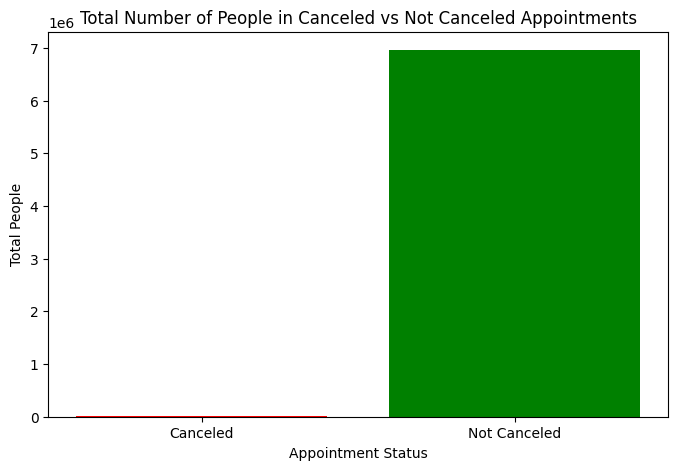

In [16]:
# bar chart comparing appointment cancellation statuses

# Calculate total people for canceled and non-canceled appointments
total_cancel = df_cancel['TOTAL_PEOPLE'].sum()
total_nocancel = df_nocancel['TOTAL_PEOPLE'].sum()

# Data for the bar chart
categories = ['Canceled', 'Not Canceled']
totals = [total_cancel, total_nocancel]

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(categories, totals, color=['red', 'green'])
plt.title('Total Number of People in Canceled vs Not Canceled Appointments')
plt.ylabel('Total People')
plt.xlabel('Appointment Status')
plt.show()


Total persons isn't recorded in cancelled appointments. I suggest we collect the anticipated number of attendees to determine cancellation trends.


NaT values in df_cancel APPT_START_DATE: 188


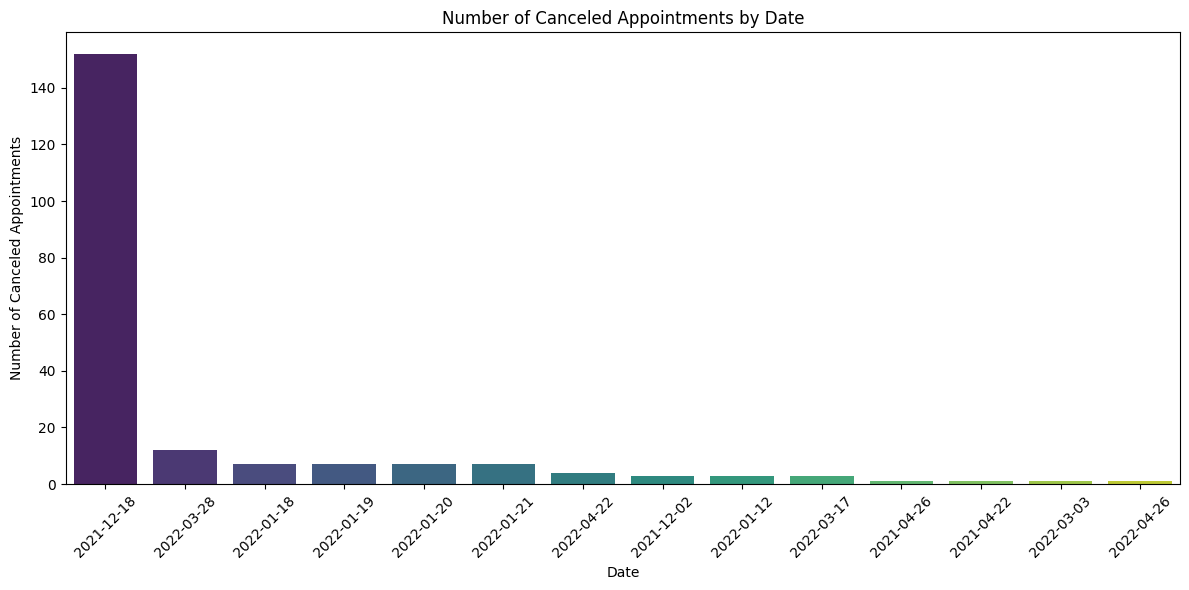

In [17]:
import seaborn as sns

# Ensure the columns are treated as strings before conversion
df_cancel['APPT_START_DATE'] = df_cancel['APPT_START_DATE'].astype(str)

# Convert date columns to datetime, handling any errors
df_cancel['APPT_START_DATE'] = pd.to_datetime(df_cancel['APPT_START_DATE'].str.strip(), errors='coerce')

# Check for NaT values after conversion
print("NaT values in df_cancel APPT_START_DATE:", df_cancel['APPT_START_DATE'].isna().sum())

# Extract just the date from the datetime for grouping
df_cancel['Date'] = df_cancel['APPT_START_DATE'].dt.date

# 2. Count of appointments by date for df_cancel
plt.figure(figsize=(12, 6))
sns.countplot(data=df_cancel, x='Date', order=df_cancel['Date'].value_counts().index, palette='viridis')
plt.title('Number of Canceled Appointments by Date')
plt.xticks(rotation=45)
plt.ylabel('Number of Canceled Appointments')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


Let's visualize locations and meeting rooms. Meeting rooms are:
* EEOB: Eisenhower Executive Office Building
* NEOB: New Executive Office Building
* OEOB: Old Executive Office Building
* VPR: Vice President's Residence
* WH: White House


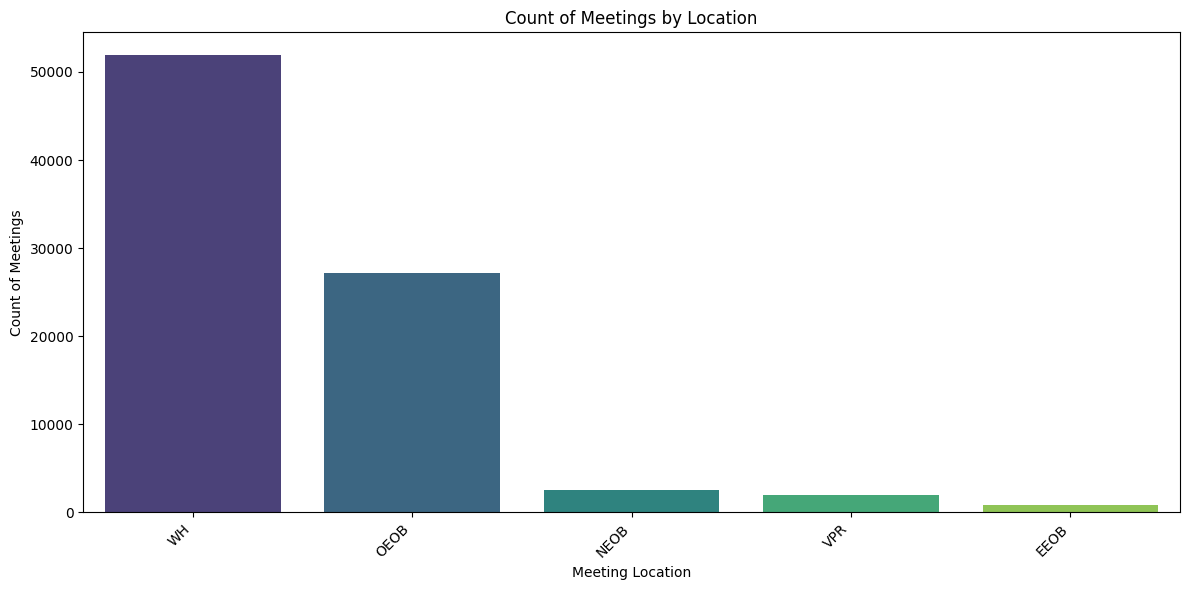

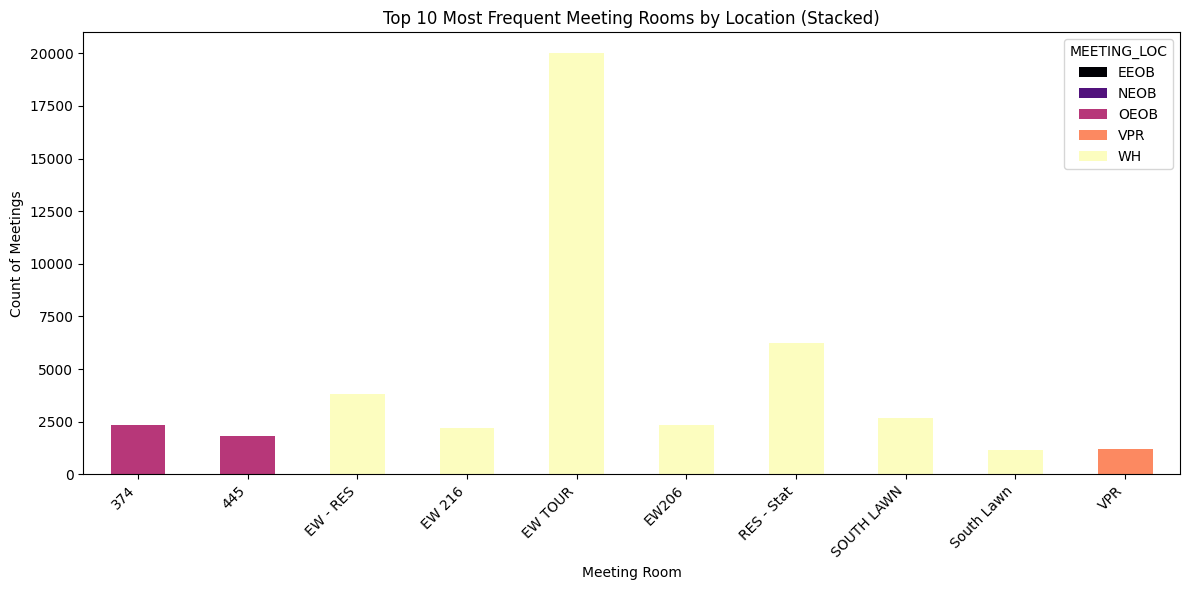

In [18]:
# Visualization 1: Count of Meetings by Location
plt.figure(figsize=(12, 6))
sns.countplot(data=df_locn, x='MEETING_LOC', order=df_locn['MEETING_LOC'].value_counts().index, palette='viridis')
plt.title('Count of Meetings by Location')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Meeting Location')
plt.ylabel('Count of Meetings')
plt.tight_layout()
plt.show()

top_10_rooms = df_locn['MEETING_ROOM'].value_counts().nlargest(10).index

# Step 2: Filter the dataframe for just the top 10 rooms
df_top_rooms = df_locn[df_locn['MEETING_ROOM'].isin(top_10_rooms)]

# Step 3: Create a pivot table to count meetings by room and location
pivot_table = df_top_rooms.pivot_table(index='MEETING_ROOM', columns='MEETING_LOC', aggfunc='size', fill_value=0)

# Step 4: Plot a stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='magma')

plt.title('Top 10 Most Frequent Meeting Rooms by Location (Stacked)')
plt.xlabel('Meeting Room')
plt.ylabel('Count of Meetings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Evidently, collection practices don't account for discrepancies in capitalization and spelling. Additionally, some rooms are numbered, but no dictionary readily exists. Future collection practices should more consistently record rooms according to a standard format. 

Most visits sensibly occur in the Touring location, with other public locations leading the way.


Furthermore, most meetings are in the WH location, with the minority in the remaining locations. This visual stresses the importance of efficient organization and scheduling for meetings within the White House.

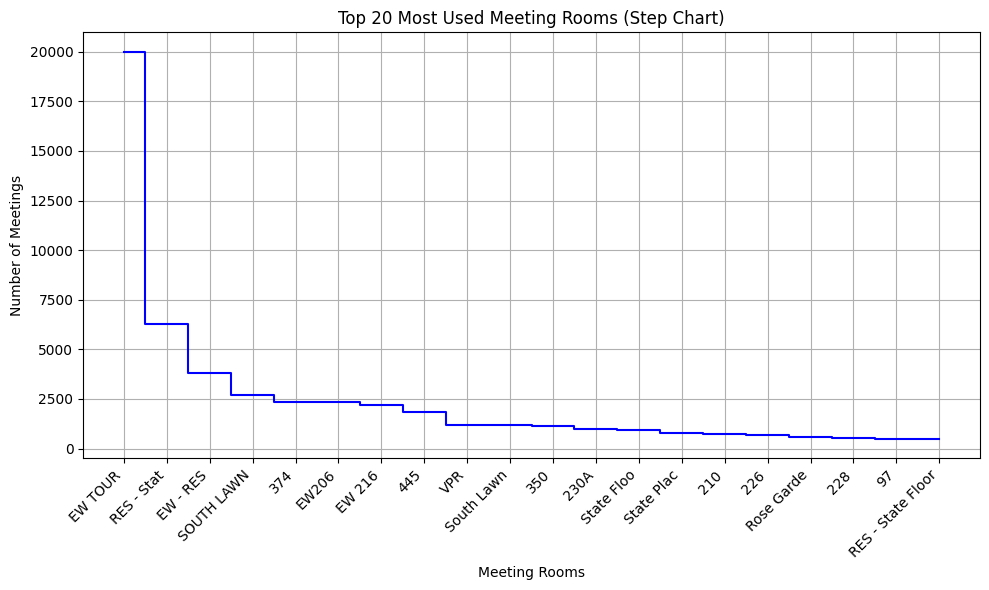

In [19]:
room_counts = df_locn['MEETING_ROOM'].value_counts().head(20)  # Top 20 rooms

# Sort the values by rank
room_counts = room_counts.sort_values(ascending=False)

# Plot a step chart
plt.figure(figsize=(10, 6))
plt.step(range(len(room_counts)), room_counts, where='mid', label='Number of Meetings', color='blue')

# Set x-ticks and labels
plt.xticks(ticks=range(len(room_counts)), labels=room_counts.index, rotation=45, ha='right')

# Labeling the chart
plt.xlabel('Meeting Rooms')
plt.ylabel('Number of Meetings')
plt.title('Top 20 Most Used Meeting Rooms (Step Chart)')
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


Grouping the meeting rooms by location, the White House touring location is the most popular, followed by the old executive office building.


In [20]:
# Safely convert TOA and TOD
df_time = df_tim.copy()
df_time['TOA'] = pd.to_datetime(df_time['TOA'], format='mixed', errors='coerce')
df_time['TOD'] = pd.to_datetime(df_time['TOD'], format='mixed', errors='coerce')

# Drop rows where we couldn't parse the datetime
df_time = df_time.dropna(subset=['TOA', 'TOD'])
# Extract date only (drop time)
df_time['visit_date'] = df_time['TOA'].dt.date
# Count visits per date
daily_visits = df_time.groupby('visit_date').size()

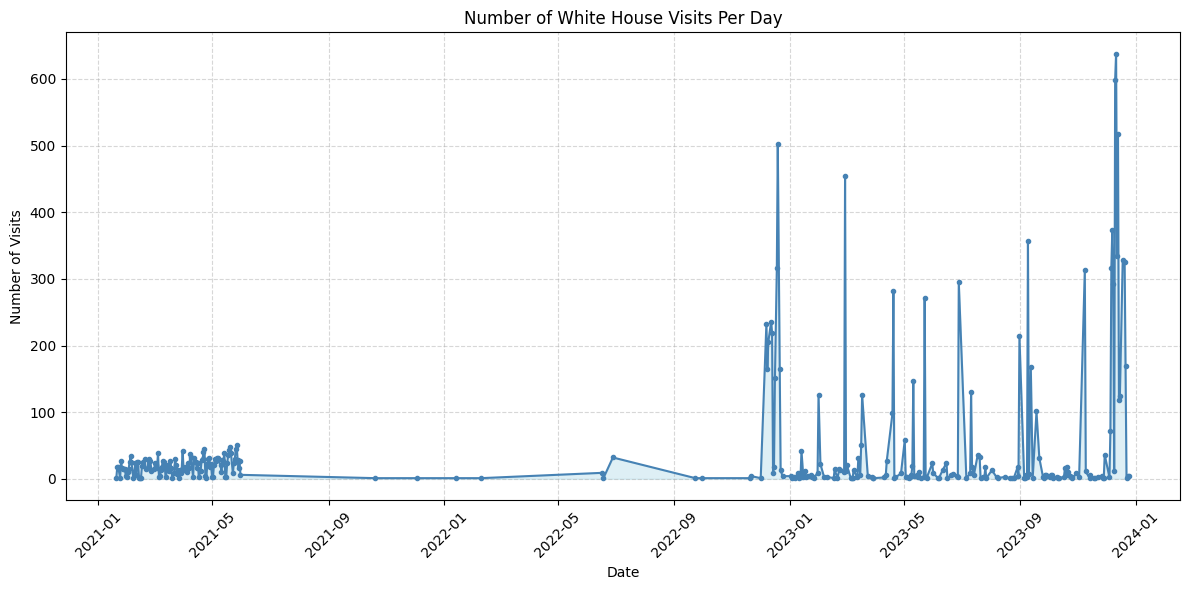

In [21]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_visits.index, daily_visits.values, marker='.', linestyle='-', color='steelblue')

plt.title("Number of White House Visits Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Visits")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.fill_between(daily_visits.index, daily_visits.values, color='lightblue', alpha=0.4)
plt.tight_layout()
plt.show()


The variance of the number of visits before and after COVID-19 is astounding. It's possible that visits were occuring on more days before, but now, more visits are occuring on less days, explaining the high variance. We don't have data included prior to 2021, so it's hard to know what other trends have changed, as we have three distinct patterns of variance.

# Summary
## Audience:
The primary audience for this document are event organizers and security staff at the White House. These individuals are responsible for planning and coordinating events and visits, and they possess a moderate understanding of the WH Log data. They’ll need insights into visit patterns to enhance the efficiency and consistency of future visits, particularly in the context of changes brought about by the COVID-19 pandemic.
## Purpose
The purpose is to introduce an exploratory analysis of White House visit logs and identify opportunities for enhancing data collection processes. The analysis highlights the discrepancies in data collection alongside the scheduling variance before and after COVID-19. The call to action is for the event organizers to take steps to improve data entry practices, further investigate scheduling trends, and implement more robust data management practices. The ultimate goal is to streamline event planning and improve the efficiency of future visits by understanding and addressing inconsistencies in the data.
## Medium/Design
The information is presented in a technical report format, designed as a quick mock-up that precedes more formal analysis. The document includes code snippets, visualizations, and explanatory text, organized logically using markdown cells. The visualizations, such as bar charts, line charts, and scatterplots with time, provide visual representations of the trends and patterns discussed in the text.
In terms of design, Gestalt’s principles are mostly considered in the visualizations, as the document composition of a notebook is already fairly clean. The use of color is highlights key differences and groupings, notably in the Room visualization. Some improvement could be lent to the line charts by engineering smoothing variables, but the purpose of the report doesn’t justify that level of aesthetic consideration.
## Ethical Considerations
Ethical considerations in this document focus on the actions taken as a result of the analysis rather than personal data protection. The trends implicate the importance of cleaning data entry processes to ensure that scheduling optimizations actually improve efficiency and don’t waste the time of visitors and staff alike.